In [1]:
### imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from matplotlib.colors import ListedColormap
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
import keras

import os
import sys

dep_dir = os.path.abspath('dep/')
sys.path.append(dep_dir)

from plotting import plot_model_history, make_roc, plot_confusion_matrix
from roc_helper import plot_roc

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

2025-02-16 14:20:33.626502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# !wget -O dep/plotting.py https://raw.githubusercontent.com/jmduarte/phys139_239/main/notebooks/plotting.py

--2025-02-15 13:35:09--  https://raw.githubusercontent.com/jmduarte/phys139_239/main/notebooks/plotting.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5221 (5,1K) [text/plain]
Saving to: ‘dep/plotting.py’

dep/plotting.py     100%[===================>]   5,10K  --.-KB/s    in 0s      

2025-02-15 13:35:09 (14,5 MB/s) - ‘dep/plotting.py’ saved [5221/5221]



In [69]:
# !wget -O dep/roc_helper.py https://raw.githubusercontent.com/jmduarte/phys139_239/main/homeworks/homework_2/code/roc_helper.py


--2025-02-15 16:18:19--  https://raw.githubusercontent.com/jmduarte/phys139_239/main/homeworks/homework_2/code/roc_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 825 [text/plain]
Saving to: ‘dep/roc_helper.py’

dep/roc_helper.py   100%[===================>]     825  --.-KB/s    in 0s      

2025-02-15 16:18:19 (14,8 MB/s) - ‘dep/roc_helper.py’ saved [825/825]



# 1. B

previous (computational methods work)[https://github.com/diodeamy/ComputationalMethods]

# 2. Duarte's Hands On

copied from @JMDuarte

## - hands-on 2: Classifying LHC collisions

goal: discriminate $H \rightarrow \tau^+ \tau^-$ from backgorund (such as $t\overline{t}$)

In [2]:
# ! wget https://raw.githubusercontent.com/k-woodruff/bdt-tutorial/master/data/training_10k.csv -O data/training_10k.csv

In [2]:
data = pd.read_csv("data/training_10k.csv")

In [3]:
print("Size of data: {}".format(data.shape))
print("Number of events: {}".format(data.shape[0]))
print("Number of columns: {}".format(data.shape[1]))

print("\nList of features in dataset:")
for col in data.columns:
    print(col)

Size of data: (10000, 33)
Number of events: 10000
Number of columns: 33

List of features in dataset:
EventId
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
DER_lep_eta_centrality
PRI_tau_pt
PRI_tau_eta
PRI_tau_phi
PRI_lep_pt
PRI_lep_eta
PRI_lep_phi
PRI_met
PRI_met_phi
PRI_met_sumet
PRI_jet_num
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi
PRI_jet_all_pt
Weight
Label


In [6]:
# # look at column labels --- notice last one is "Label" and first is "EventId" also "Weight"
# print(f"Number of signal events: {len(data[data.Label == 's'])}")
# print(f"Number of background events: {len(data[data.Label == 'b'])}")
# print(f"Fraction signal: {len(data[data.Label == 's'])/(len(data[data.Label == 's']) + len(data[data.Label == 'b']))}")


In [7]:
# plt.figure()


# fig, axs = plt.subplots(8, 4, figsize=(40, 80))

# for ix, ax in enumerate(axs.reshape(-1)):
#     col = data.columns[ix + 1]
#     if col == "Weight" or col == "Label":
#         continue
#     signal = data[col][data.Label == "s"].to_numpy()
#     mask_signal = signal > -999
#     background = data[col][data.Label == "b"].to_numpy()
#     mask_background = background > -999
#     xmin = min(np.min(background[mask_background]), np.min(signal[mask_signal]))
#     xmax = max(np.max(background[mask_background]), np.max(signal[mask_signal]))

#     ax.hist(signal[mask_signal], bins=np.linspace(xmin, xmax, 51), alpha=0.5, label="signal", density=True)
#     ax.hist(background[mask_background], bins=np.linspace(xmin, xmax, 51), alpha=0.5, label="background", density=True)

#     ax.set_xlabel(col, fontsize=40)
#     ax.set_xlabel(col, fontsize=40)
#     ax.tick_params(axis="both", which="major", labelsize=40)
#     ax.legend(fontsize=40)
# plt.tight_layout()
# plt.show()

In [4]:
data["Label"] = data.Label.astype("category")

In [5]:
data_train = data[:8000]
data_test = data[8000:]
print(f"Number of training samples: {len(data_train)}")
print(f"Number of testing samples: {len(data_test)}")
print()
print(f"Number of signal events in training set: {len(data_train[data_train.Label == 's'])}")
print(f"Number of background events in training set: {len(data_train[data_train.Label == 'b'])}")
print(
    f"Fraction signal: {len(data_train[data_train.Label == 's'])/(len(data_train[data_train.Label == 's']) + len(data_train[data_train.Label == 'b']))}"
)


Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688
Number of background events in training set: 5312
Fraction signal: 0.336


In [6]:
# extract feature names by removing the first and last two columns (have no prefix, not to be used as features)
feature_names = list(data.columns[1:-2])

In [7]:
# print(type(data_test.Label))

In [8]:
# create the DMatrix objects
trainDM = xgb.DMatrix(data=data_train[feature_names], label=data_train.Label.cat.codes, 
                      missing=-999.0, feature_names=feature_names)
testDM = xgb.DMatrix(data=data_test[feature_names], label=data_test.Label.cat.codes,
                   missing=-999.0, feature_names=feature_names)
print(f"Number of training samples: {trainDM.num_row()}")
print(f"Number of testing samples: {testDM.num_row()}")
print()
print(f"Number of signal events in training set: {len(np.where(trainDM.get_label())[0])}")

Number of training samples: 8000
Number of testing samples: 2000

Number of signal events in training set: 2688


In [9]:
param = {}

param["seed"] = 42  # set seed for reproducibility

# Booster parameters
param["eta"] = 0.1  # learning rate
param["max_depth"] = 10  # maximum depth of a tree
param["subsample"] = 0.8  # fraction of events to train tree on
param["colsample_bytree"] = 0.8  # fraction of features to train tree on

# Learning task parameters
param["objective"] = "binary:logistic"  # objective function
param["eval_metric"] = "error"  # evaluation metric for cross validation, note: last one is used for early stopping
param = list(param.items())

num_trees = 100  # number of trees to make


In [12]:
booster = xgb.train(param, trainDM, num_boost_round=num_trees)
print(booster.eval(testDM))

[0]	eval-error:0.17449999999999999


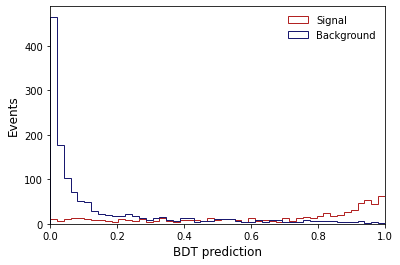

In [39]:
predictions = booster.predict(testDM)
labels = testDM.get_label().astype(bool)

# plot signal and background predictions, separately
plt.figure()
plt.hist(predictions[labels], bins=np.linspace(0, 1, 50), histtype="step", color="firebrick", label="Signal")
plt.hist(predictions[~labels], bins=np.linspace(0, 1, 50), histtype="step", color="midnightblue", label="Background")
# make the plot readable
plt.xlabel("BDT prediction", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.xlim(0, 1)
plt.show()

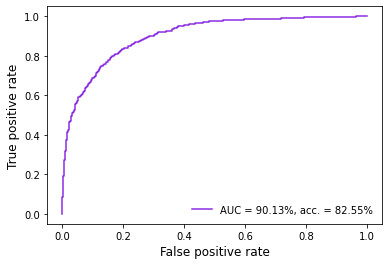

In [40]:
fpr, tpr, _ = roc_curve(labels, predictions)
auc_score = auc(fpr, tpr)
acc_score = accuracy_score(labels, predictions > 0.5)

# plot TPR vs. FPR (ROC curve)
plt.figure()
plt.plot(fpr, tpr, color="blueviolet", label=f"AUC = {auc_score*100:.2f}%, acc. = {acc_score*100:.2f}%")
# make the plot readable
plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.legend(frameon=False)
plt.show()

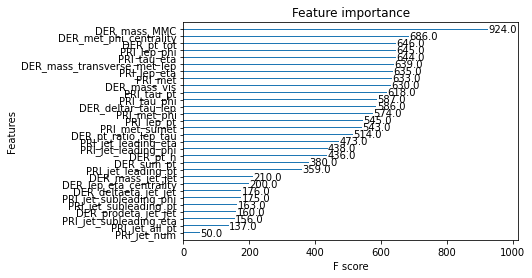

In [41]:
xgb.plot_importance(booster, grid=False)
plt.show()

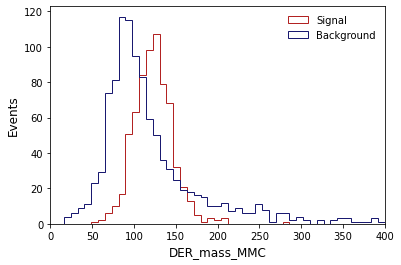

In [42]:
plt.figure()
plt.hist(
    data_test.DER_mass_MMC[data_test.Label == "s"],
    bins=np.linspace(0, 400, 50),
    histtype="step",
    color="firebrick",
    label="Signal",
)
plt.hist(
    data_test.DER_mass_MMC[data_test.Label == "b"],
    bins=np.linspace(0, 400, 50),
    histtype="step",
    color="midnightblue",
    label="Background",
)

plt.xlim(0, 400)
plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.show()

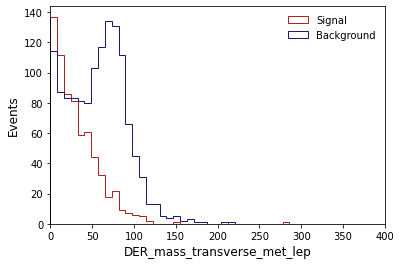

In [43]:
plt.figure()
plt.hist(
    data_test.DER_mass_transverse_met_lep[data_test.Label == "s"],
    bins=np.linspace(0, 400, 50),
    histtype="step",
    color="firebrick",
    label="Signal",
)
plt.hist(
    data_test.DER_mass_transverse_met_lep[data_test.Label == "b"],
    bins=np.linspace(0, 400, 50),
    histtype="step",
    color="midnightblue",
    label="Background",
)

plt.xlim(0, 400)
plt.xlabel("DER_mass_transverse_met_lep", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.show()

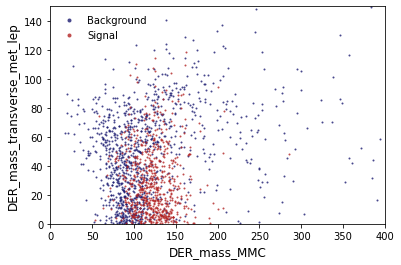

In [44]:
plt.figure()

mask_b = np.array(data_test.Label == "b")
mask_s = np.array(data_test.Label == "s")

DER_mass_MMC = np.array(data_test.DER_mass_MMC)
DER_mass_transverse_met_lep = np.array(data_test.DER_mass_transverse_met_lep)

plt.plot(
    DER_mass_MMC[mask_b],
    DER_mass_transverse_met_lep[mask_b],
    "o",
    markersize=2,
    color="midnightblue",
    markeredgewidth=0,
    alpha=0.8,
    label="Background",
)
plt.plot(
    DER_mass_MMC[mask_s],
    DER_mass_transverse_met_lep[mask_s],
    "o",
    markersize=2,
    color="firebrick",
    markeredgewidth=0,
    alpha=0.8,
    label="Signal",
)
plt.xlim(0, 400)
plt.ylim(0, 150)
plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("DER_mass_transverse_met_lep", fontsize=12)
plt.legend(frameon=False, numpoints=1, markerscale=2)
plt.show()

## Exercise (with only top two features)

In [47]:
top_features = ["DER_mass_MMC", "DER_mass_transverse_met_lep"]

In [48]:
train_topDM = xgb.DMatrix(data=data_train[top_features], label=data_train.Label.cat.codes,
                         missing=-999.0, feature_names=top_features)
test_topDM = xgb.DMatrix(data=data_test[top_features], label=data_test.Label.cat.codes,
                        missing=-999.0, feature_names=top_features)

In [49]:
### params not changed
booster_top = xgb.train(param, train_topDM, num_boost_round=num_trees)
print(booster_top.eval(test_topDM))

[0]	eval-error:0.22700000000000001


In [50]:
print(booster_top.eval(train_topDM))

[0]	eval-error:0.19412499999999999


In [51]:
predictions_top = booster_top.predict(test_topDM)
labels_top = test_topDM.get_label().astype(bool)

predictions_learn_top =  booster_top.predict(train_topDM)
labels_learn_top = train_topDM.get_label().astype(bool)

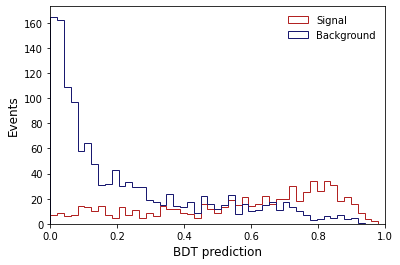

In [52]:
# plot signal and background predictions, separately
plt.figure()
plt.hist(predictions_top[labels], bins=np.linspace(0, 1, 50), histtype="step", color="firebrick", label="Signal")
plt.hist(predictions_top[~labels], bins=np.linspace(0, 1, 50), histtype="step", color="midnightblue", label="Background")
# make the plot readable
plt.xlabel("BDT prediction", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.xlim(0, 1)
plt.show()

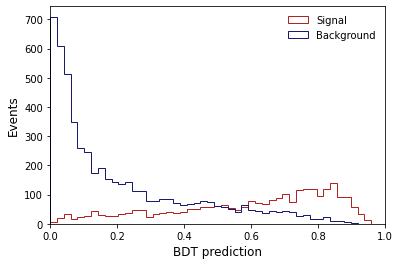

In [53]:
# plot signal and background predictions, separately
plt.figure()
plt.hist(predictions_learn_top[labels_learn_top], bins=np.linspace(0, 1, 50), histtype="step", color="firebrick", label="Signal")
plt.hist(predictions_learn_top[~labels_learn_top], bins=np.linspace(0, 1, 50), histtype="step", color="midnightblue", label="Background")
# make the plot readable
plt.xlabel("BDT prediction", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(frameon=False)
plt.xlim(0, 1)
plt.show()

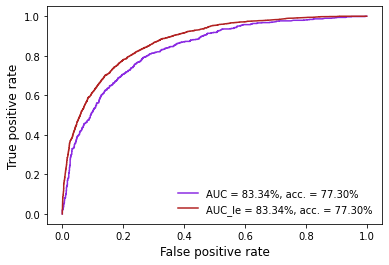

In [54]:
fpr_top, tpr_top, _ = roc_curve(labels_top, predictions_top)
auc_score_top = auc(fpr_top, tpr_top)
acc_score_top = accuracy_score(labels_top, predictions_top > 0.5)

fpr_learn_top, tpr_learn_top, _ = roc_curve(labels_learn_top, predictions_learn_top )
auc_score_learn_top = auc(fpr_learn_top, tpr_learn_top)
acc_score_learn_top = accuracy_score(labels_learn_top, predictions_learn_top > 0.5)

# plot TPR vs. FPR (ROC curve)
plt.figure()
plt.plot(fpr_top, tpr_top, color="blueviolet", label=f"AUC = {auc_score_top*100:.2f}%, acc. = {acc_score_top*100:.2f}%")
plt.plot(fpr_learn_top, tpr_learn_top, color="firebrick", label=f"AUC_le = {auc_score_top*100:.2f}%, acc. = {acc_score_top*100:.2f}%")
# make the plot readable
plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.legend(frameon=False)
plt.show()

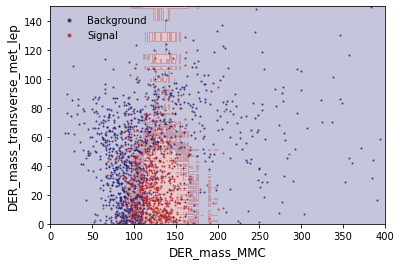

In [55]:
# first get a mesh grid
x_grid, y_grid = np.meshgrid(np.linspace(0, 400, 1000), np.linspace(0, 150, 1000))
# convert grid into DMatrix
matrix_grid = xgb.DMatrix(
    data=np.c_[x_grid.ravel(), y_grid.ravel()], missing=-999.0, feature_names=top_features
)
# run prediction for every value in grid
z_grid = booster_top.predict(matrix_grid)
# reshape
z_grid = z_grid.reshape(x_grid.shape)


plt.figure()
# plot decision boundary
ax = plt.subplot(111)
cm = ListedColormap(["midnightblue", "firebrick"])
plt.contourf(x_grid, y_grid, z_grid, levels=[0, 0.5, 1], cmap=cm, alpha=0.25)
# overlaid with test data points
plt.plot(
    DER_mass_MMC[mask_b],
    DER_mass_transverse_met_lep[mask_b],
    "o",
    markersize=2,
    color="midnightblue",
    markeredgewidth=0,
    alpha=0.8,
    label="Background",
)
plt.plot(
    DER_mass_MMC[mask_s],
    DER_mass_transverse_met_lep[mask_s],
    "o",
    markersize=2,
    color="firebrick",
    markeredgewidth=0,
    alpha=0.8,
    label="Signal",
)
ax.set_ylim(0,150)
ax.set_xlim(0,400)
plt.xlabel("DER_mass_MMC", fontsize=12)
plt.ylabel("DER_mass_transverse_met_lep", fontsize=12)
plt.legend(frameon=False, numpoints=1, markerscale=2)
plt.show()

# THE SHAPE LOOKS BAD
I think there IS overfitting because there is a lot of fragmetnation  (so areas very close to each other that have very volatile behaviour in what is predicted)

but when plotting the (BDT) predictions for the test data, the graph looks very similar to the one for test data, so I cannot really see from this how to deduce overfitting. 

## - hands-on 3

In [3]:
data = fetch_openml("hls4ml_lhc_jets_hlf", parser="auto")
X, y = data["data"], data["target"]

In [4]:
print(f"Feature names: {data['feature_names']}")
print(f"Target names: {y.dtype.categories.to_list()}")
print(f"Shapes: {X.shape}, {y.shape}")
print(f"Inputs: {X}")
print(f"Targets: {y}")

Feature names: ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
Target names: ['g', 'q', 't', 'w', 'z']
Shapes: (830000, 16), (830000,)
Inputs:            zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0      -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1      -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2      -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3      -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4      -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   
...          ...         ...         ...         ...         ...         ...   
829995 -3.575320    0.473246    0.040693    0.005605    0.053711    0.004402   
829996 -2.408292    0.429539    0.0400

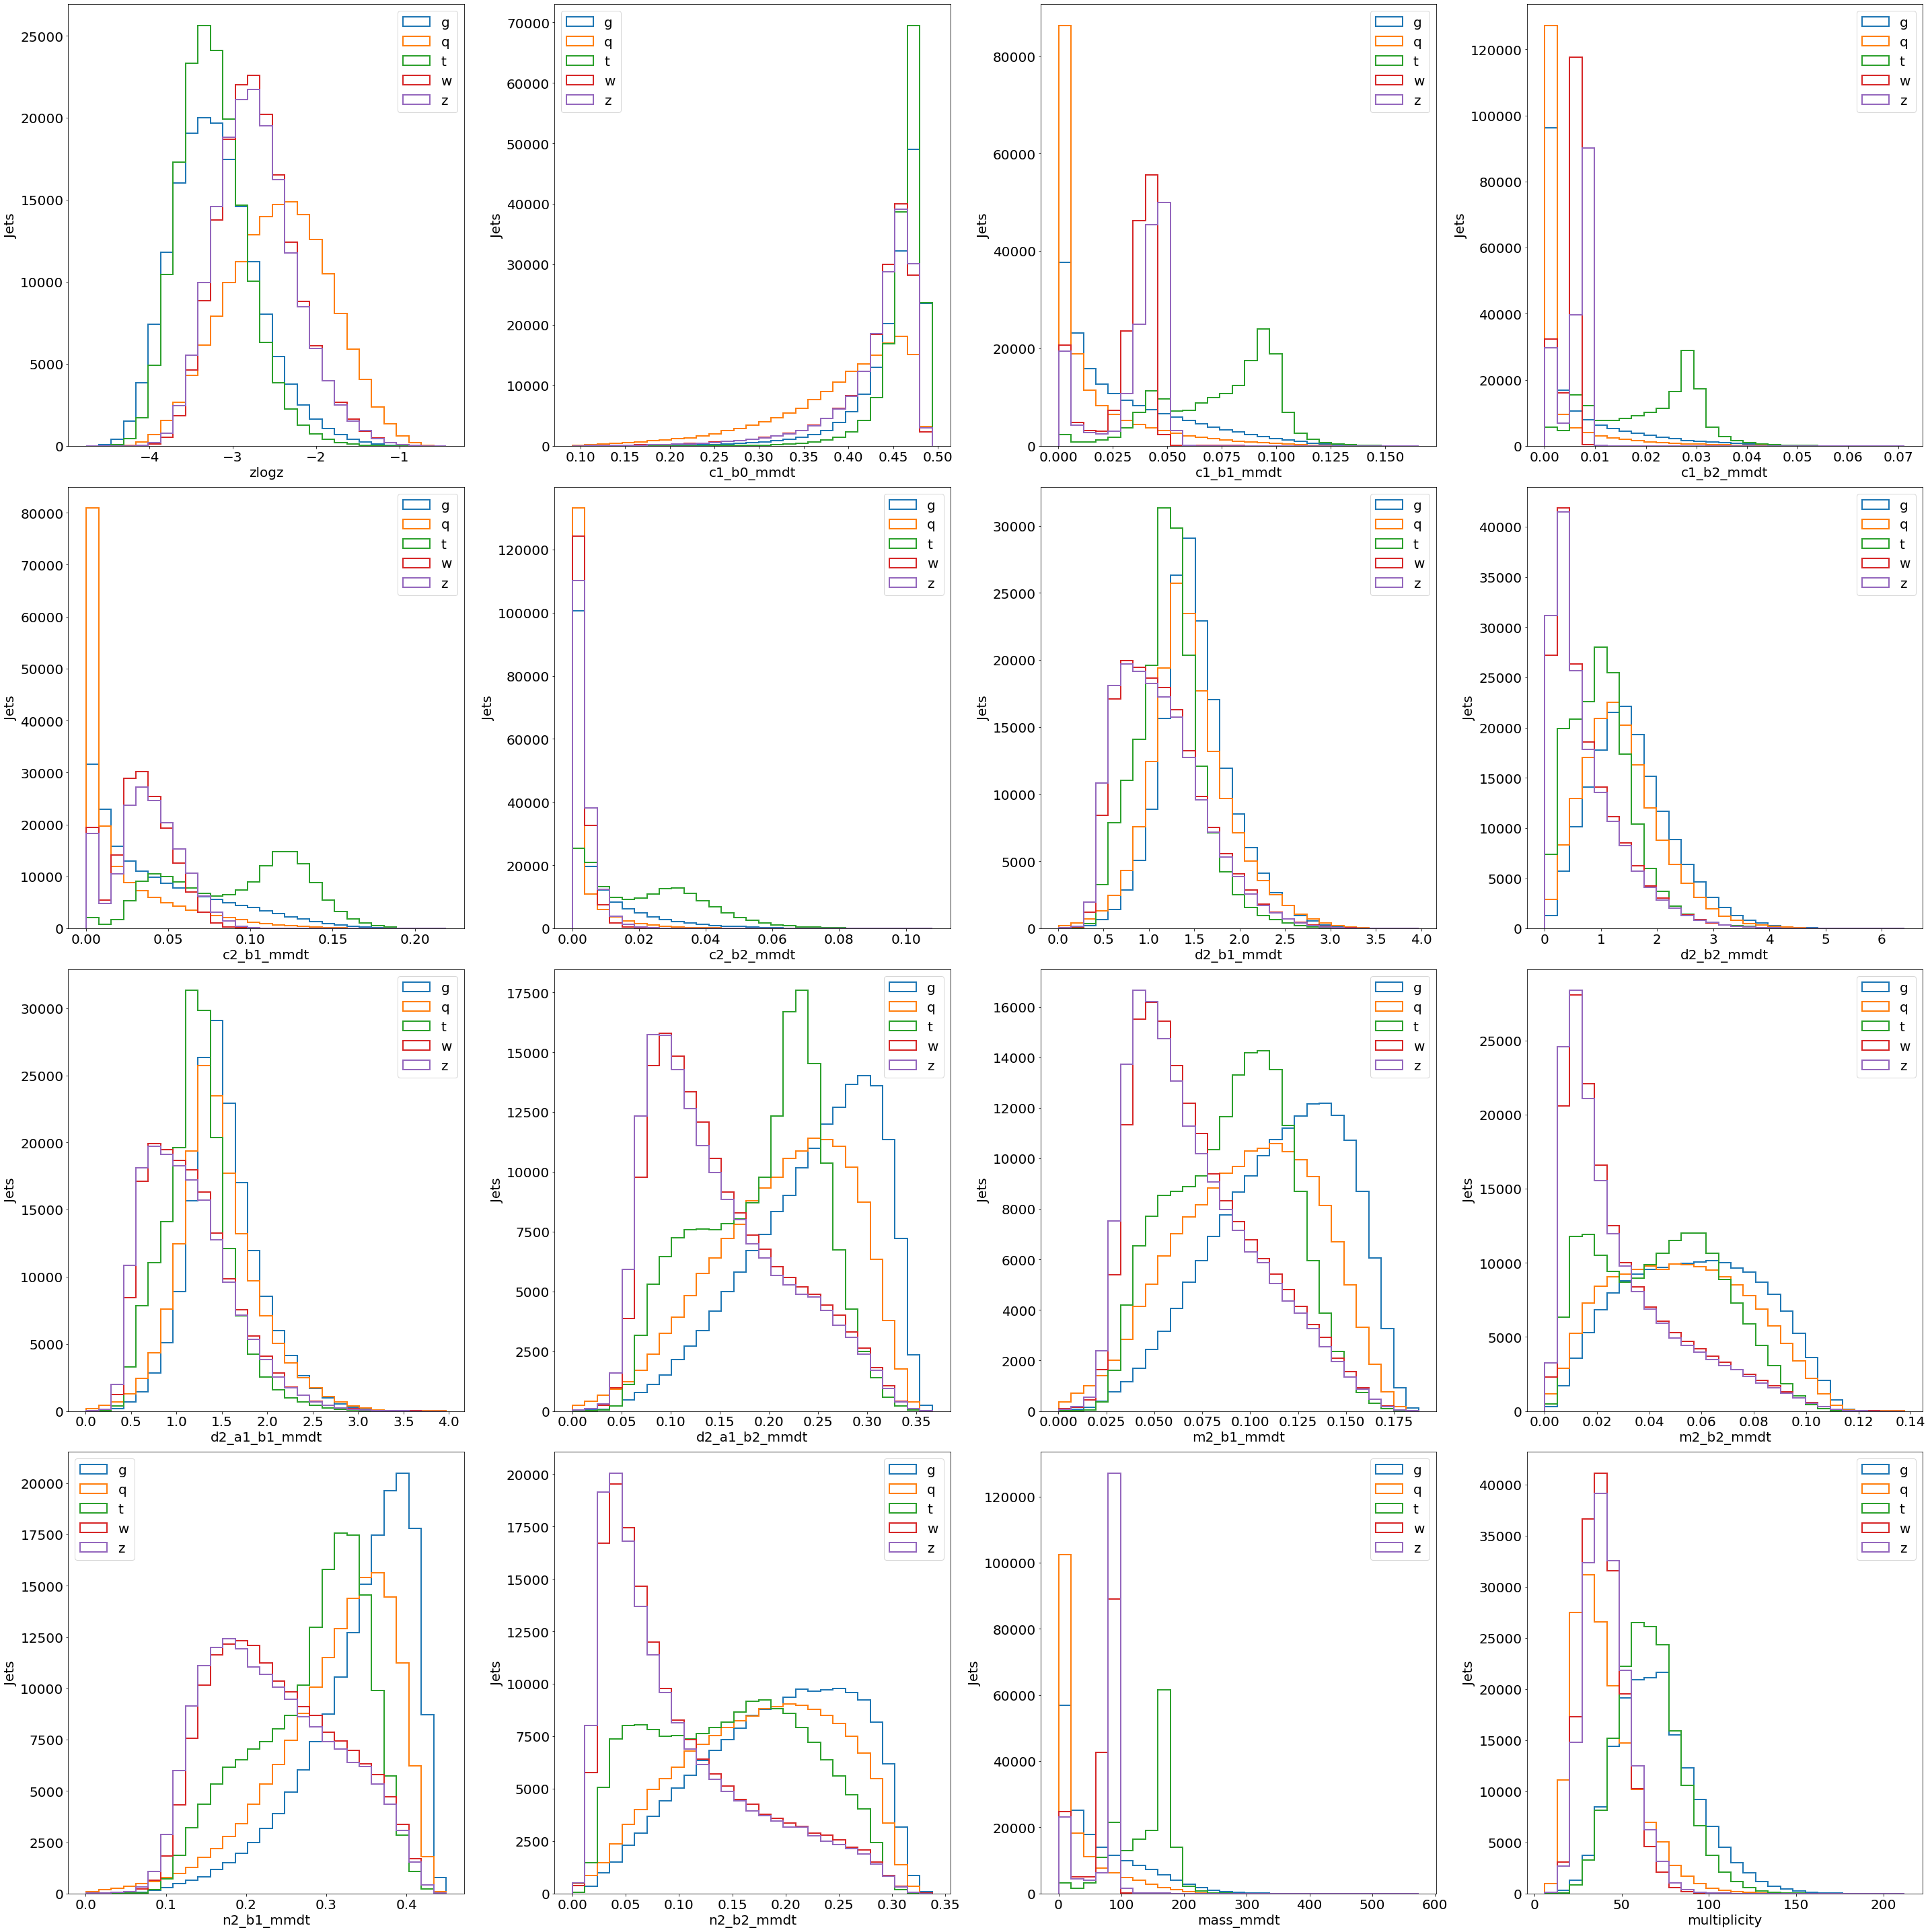

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(40, 40))

for ix, ax in enumerate(axs.reshape(-1)):
    feat = data["feature_names"][ix]
    bins = np.linspace(np.min(X[:][feat]), np.max(X[:][feat]), 30)
    for c in y.dtype.categories:
        ax.hist(X[y == c][feat], bins=bins, histtype="step", label=c, lw=2)
    ax.set_xlabel(feat, fontsize=20)
    ax.set_ylabel("Jets", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=20, loc="best")
plt.tight_layout()
plt.show()

In [5]:
le = LabelEncoder()
y_onehot = le.fit_transform(y)
y_onehot = to_categorical(y_onehot, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print(y[:5])
print(y_onehot[:5])

0    g
1    w
2    t
3    z
4    w
Name: class, dtype: category
Categories (5, object): ['g', 'q', 't', 'w', 'z']
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


## relu activated neural network

- 3 hidden layers(64, 32, 32 neurons)
- output layer has 5 neurons (corresponds to the 5 classes of particle sources of jets)
- softmax activation layer converts the resulting vector of values to a probability distribtution

In [6]:
model = Sequential(name="sequantial1")
model.add(Dense(64, input_shape=(16,), name="fc1"))
model.add(Activation(activation="relu", name="relu1"))
model.add(Dense(32, name="fc2"))
model.add(Activation(activation="relu", name="relu2"))
model.add(Dense(32, name="fc3"))
model.add(Activation(activation="relu", name="relu3"))
model.add(Dense(5, name="fc4"))
model.add(Activation(activation="softmax", name="softmax"))
model.summary()

/Users/ruxi/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequantial1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer="sgd", loss=["categorical_crossentropy"], metrics=["accuracy"])

In [8]:
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25,
                    shuffle=True, verbose=0)
%time

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 26.7 µs


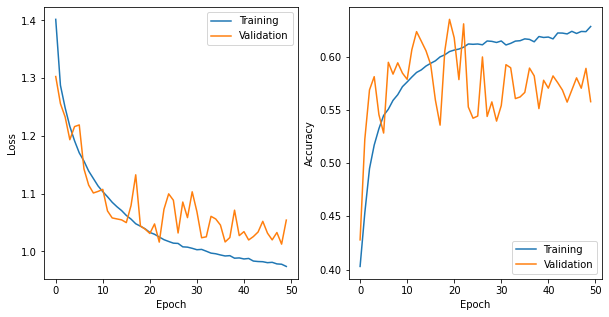

In [9]:
plot_model_history(history)

In [10]:
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

Accuracy: 0.5575060240963855


<Figure size 360x360 with 0 Axes>

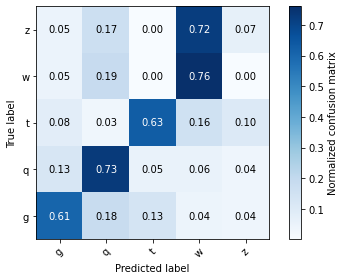

In [11]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

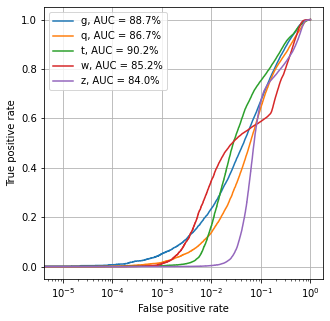

In [12]:
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

## Exercise 1 - adding scaler to inputs

In [16]:
scaler = StandardScaler()
X_train_val_sc = scaler.fit_transform(X_train_val)
X_test_sc = scaler.transform(X_test)

In [17]:
history_sc = model.fit(X_train_val_sc, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, 
                       shuffle=True, verbose=0)


Accuracy: 0.763566265060241


<Figure size 360x360 with 0 Axes>

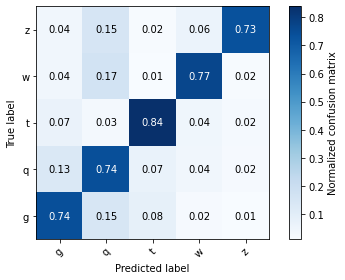

In [18]:
y_keras_sc = model.predict(X_test_sc, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras_sc, axis=1))}")

plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras_sc, classes=le.classes_, normalize=True)

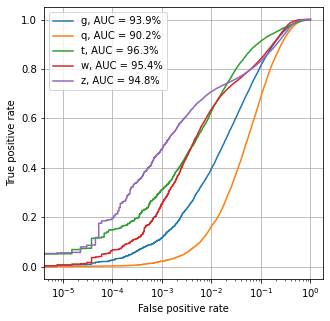

In [19]:
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras_sc, le.classes_)

- the accuracy is around 20% better for the scaled data

- it appears that it's also better at correctly classifying w and z bosons (but having reran the training step several times, i observed that this process is very volatile and sometimes it does not even recognize the z boson)

## Exercise 2 - adding L1 regularisation

in the lecture we changed one feature at a time so I decided to also do that here (ie did not apply both scaling and regularisation)

In [20]:
model2 = Sequential(name="sequantial1")
model2.add(Dense(64, input_shape=(16,), name="fc1", kernel_regularizer=l1(0.01)))
model2.add(Activation(activation="relu", name="relu1"))
model2.add(Dense(32, name="fc2"))
model2.add(Activation(activation="relu", name="relu2"))
model2.add(Dense(32, name="fc3"))
model2.add(Activation(activation="relu", name="relu3"))
model2.add(Dense(5, name="fc4"))
model2.add(Activation(activation="softmax", name="softmax"))
model2.summary()

model2.compile(optimizer="sgd", loss=["categorical_crossentropy"], metrics=["accuracy"])

/Users/ruxi/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequantial1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history2 = model2.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25,
                    shuffle=True, verbose=0)
%time

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 45.1 µs


Accuracy: 0.6438072289156627


<Figure size 360x360 with 0 Axes>

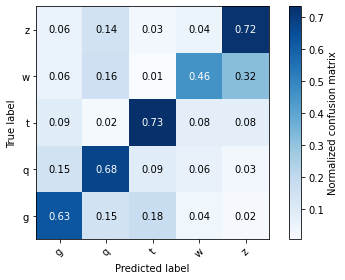

In [22]:
y_keras_2 = model2.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras_2, axis=1))}")

plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras_2, classes=le.classes_, normalize=True)

- the accuracy also increases by around 10%
- model is better at predicting z bosons but worse overall

## Exercise 3 - smaller learning rate

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=["categorical_crossentropy"], metrics=["accuracy"])

In [24]:
history_lr = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25,
                    shuffle=True, verbose=0)
%time

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.91 µs


In [25]:
y_keras_lr = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras_2, axis=1))}")

Accuracy: 0.6438072289156627


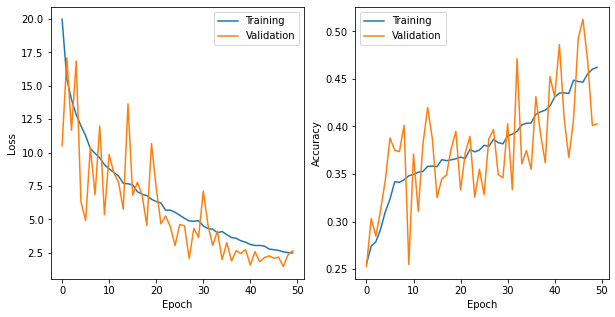

In [26]:
plot_model_history(history_lr)

## smaller learning rate = good

In [27]:
optimizer = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss=["categorical_crossentropy"], metrics=["accuracy"])

In [28]:
history_lr1 = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25,
                    shuffle=True, verbose=0)
%time

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


In [29]:
y_keras_lr1 = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras_2, axis=1))}")

Accuracy: 0.6438072289156627


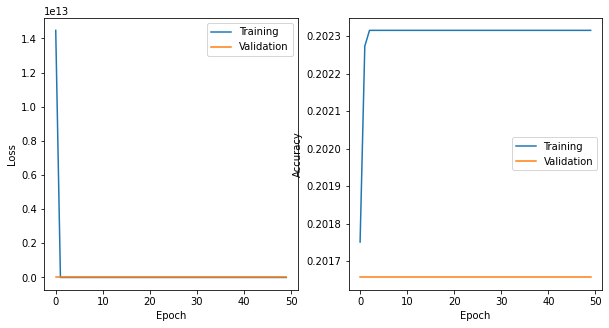

In [30]:
plot_model_history(history_lr1)

## big learning rate = bad

## Exercise 4 - Adam optimizer

In [51]:
adams_optimizer = keras.optimizers.Adam()
a_model = Sequential(name="sequantial1")
a_model.add(Dense(64, input_shape=(16,), name="fc1"))
a_model.add(Activation(activation="relu", name="relu1"))
a_model.add(Dense(32, name="fc2"))
a_model.add(Activation(activation="relu", name="relu2"))
a_model.add(Dense(32, name="fc3"))
a_model.add(Activation(activation="relu", name="relu3"))
a_model.add(Dense(5, name="fc4"))
a_model.add(Activation(activation="softmax", name="softmax"))

a_model.compile(optimizer=adams_optimizer, loss=["categorical_crossentropy"], metrics=["accuracy"])
a_model.summary()

Model: "sequantial1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
%%time
adams_history = a_model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25,
                    shuffle=True, verbose=0)

1min 22s ± 13 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Accuracy: 0.7627710843373494


<Figure size 360x360 with 0 Axes>

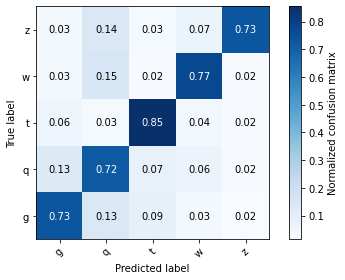

In [61]:
adams_y_keras = a_model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(adams_y_keras, axis=1))}")

plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, adams_y_keras, classes=le.classes_, normalize=True)

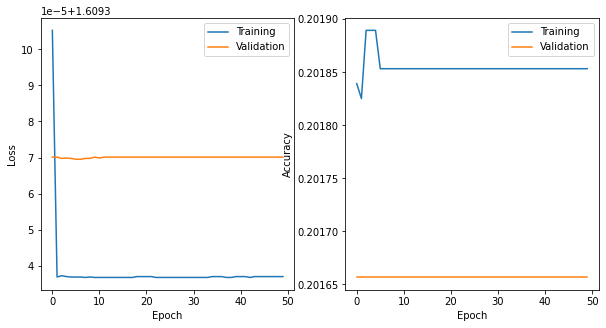

In [62]:
plot_model_history(adams_history)

- accuracy is a lot better (76%) based on the computation, but based on the history graph it's terrible
- loss curves look very odd, considering how good the confusion matrix looks, i focused on the HW in thend so I did not manage to figure out what is going wrong